# LSTM Analysis

In [1]:
import h5py
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

Using TensorFlow backend.
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/fra

## Read dataset

In [2]:
dataset_file = "../data/users.h5"
users_df = pd.read_hdf(dataset_file)
users_df = pd.DataFrame(users_df.to_records())
users_df

,time_hour,0,1,2,3,10,11,12,13,20,...,972,973,980,982,983,990,991,992,993,99300
0,2012-08-18 16:00:00,103,32,35,36,1919,667,610,642,1694,...,20,47,32,11,21,609,208,194,207,161282
1,2012-08-18 17:00:00,78,31,20,27,1348,462,429,457,1226,...,15,37,16,7,9,377,136,126,115,108600
2,2012-08-18 18:00:00,36,17,9,10,914,304,286,324,929,...,10,28,14,5,9,212,88,70,54,77076
3,2012-08-18 19:00:00,32,14,7,11,653,210,208,235,799,...,8,22,11,4,7,160,65,44,51,60118
4,2012-08-18 20:00:00,23,7,5,11,551,183,174,194,834,...,15,21,8,2,6,153,58,42,53,54592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2012-08-26 11:00:00,235,84,94,57,846,357,188,301,3308,...,55,90,38,11,27,939,260,315,364,244852
188,2012-08-26 12:00:00,219,81,77,61,928,381,207,340,3314,...,64,88,41,16,25,941,278,313,350,241728
189,2012-08-26 13:00:00,187,67,63,57,771,303,172,296,2966,...,50,79,36,17,19,876,262,299,315,220012
190,2012-08-26 14:00:00,175,57,62,56,592,200,139,253,2572,...,41,90,33,14,19,794,276,233,285,198886


### LSTM Config

In [24]:
learning_rate = 0.01
window = 12
epochs = 100
batch_size = 64
num_input = len(users_df.columns[1:])
timesteps = users_df.shape[0]
keep_rate_DROPOUT = 0.2;
optimizer = Adam(learning_rate=learning_rate)
loss_function = "mean_squared_error"
lstm_units = 50
bs = "40"


In [4]:
print("Learning rate:                   ", learning_rate)
print("epochs:                          ", epochs)
print("Keep Rate DROPOUT:               ", keep_rate_DROPOUT)

print("Number of input(Metrics):        ", num_input)
print("Time steps:                      ", timesteps)
print("Batch size:                      ", batch_size)


Learning rate:                    0.01
epochs:                           100
Keep Rate DROPOUT:                0.2
Number of input(Metrics):         400
Time steps:                       192
Batch size:                       32


## LSTM Data pre-processing

In [5]:
dataset = users_df[users_df.columns[1:]].to_numpy()
dataset

array([[   103,     32,     35, ...,    194,    207, 161282],
       [    78,     31,     20, ...,    126,    115, 108600],
       [    36,     17,      9, ...,     70,     54,  77076],
       ...,
       [   187,     67,     63, ...,    299,    315, 220012],
       [   175,     57,     62, ...,    233,    285, 198886],
       [   159,     53,     56, ...,    223,    239, 159072]])

In [6]:
train_data_len = math.ceil(len(dataset) * .8)
train_data_len

154

In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.30258303, 0.23684211, 0.33707865, ..., 0.43603133, 0.30418251,
        0.28341841],
       [0.2103321 , 0.22807018, 0.16853933, ..., 0.25848564, 0.12927757,
        0.1546292 ],
       [0.05535055, 0.10526316, 0.04494382, ..., 0.11227154, 0.01330798,
        0.07756395],
       ...,
       [0.61254613, 0.54385965, 0.65168539, ..., 0.71018277, 0.5095057 ,
        0.42699288],
       [0.56826568, 0.45614035, 0.64044944, ..., 0.53785901, 0.45247148,
        0.37534714],
       [0.50922509, 0.42105263, 0.57303371, ..., 0.51174935, 0.36501901,
        0.27801572]])

In [8]:
train_data = scaled_data[0:train_data_len, :]
train_data.shape

(154, 400)

In [9]:
test_data = scaled_data[train_data_len - window:, :]
test_data.shape

(50, 400)

In [10]:
XTrain = []
YTrain = []

for i in range(window, len(train_data)):
    XTrain.append(train_data[i-window:i])
    YTrain.append(train_data[i])

In [11]:
XTrain, YTrain = np.array(XTrain), np.array(YTrain)
print(XTrain.shape)
print(YTrain.shape)

(142, 12, 400)
(142, 400)


In [12]:
m = Sequential()
m.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(XTrain.shape[1], num_input)))
m.add(Dropout(keep_rate_DROPOUT))
m.add(LSTM(units=lstm_units))
m.add(Dropout(keep_rate_DROPOUT))
m.add(Dense(units=num_input))
m.compile(optimizer=optimizer, loss=loss_function)


Epoch 1/100
142/142 [==============================] - 0s 3ms/step - loss: 0.1944
Epoch 2/100
142/142 [==============================] - 0s 327us/step - loss: 0.0841
Epoch 3/100
142/142 [==============================] - 0s 316us/step - loss: 0.0778
Epoch 4/100
142/142 [==============================] - 0s 331us/step - loss: 0.0531
Epoch 5/100
142/142 [==============================] - 0s 329us/step - loss: 0.0398
Epoch 6/100
142/142 [==============================] - 0s 312us/step - loss: 0.0332
Epoch 7/100
142/142 [==============================] - 0s 315us/step - loss: 0.0265
Epoch 8/100
142/142 [==============================] - 0s 307us/step - loss: 0.0253
Epoch 9/100
142/142 [==============================] - 0s 299us/step - loss: 0.0253
Epoch 10/100
142/142 [==============================] - 0s 296us/step - loss: 0.0238
Epoch 11/100
142/142 [==============================] - 0s 308us/step - loss: 0.0240
Epoch 12/100
142/142 [==============================] - 0s 294us/step - los

142/142 [==============================] - 0s 289us/step - loss: 0.0085
Epoch 96/100
142/142 [==============================] - 0s 296us/step - loss: 0.0082
Epoch 97/100
142/142 [==============================] - 0s 290us/step - loss: 0.0081
Epoch 98/100
142/142 [==============================] - 0s 285us/step - loss: 0.0086
Epoch 99/100
142/142 [==============================] - 0s 292us/step - loss: 0.0085
Epoch 100/100
142/142 [==============================] - 0s 286us/step - loss: 0.0094


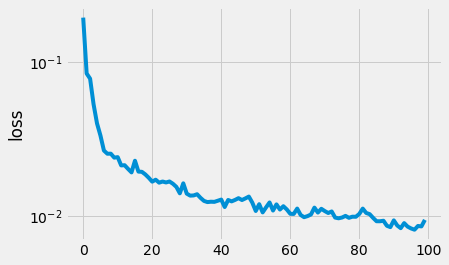

In [13]:
history = m.fit(XTrain, YTrain, epochs=epochs, batch_size=batch_size, verbose=1)

plt.figure()
plt.ylabel('loss');plt.xlabel=('epoch')
plt.semilogy(history.history['loss'])

In [14]:
XTest = []

YTest = dataset[train_data_len:]
test_data
for i in range(window, len(test_data)):
    XTest.append(test_data[i-window:i])

XTest, YTest = np.array(XTest), np.array(YTest)

x_pred = m.predict(XTest)
x_pred = scaler.inverse_transform(x_pred)
prediction = pd.DataFrame(data=x_pred, columns=users_df.columns[1:])

In [15]:
train = users_df[:train_data_len]
valid = users_df[train_data_len:]

prediction['time_hour'] = valid['time_hour'].values

prediction

,0,1,2,3,10,11,12,13,20,21,...,973,980,982,983,990,991,992,993,99300,time_hour
0,201.858841,75.082253,61.313976,66.897331,2199.529053,778.725098,693.038086,665.232788,3861.167480,1253.296631,...,80.337692,44.636086,18.118832,26.611944,859.559875,284.009674,255.370407,316.314606,239459.109375,2012-08-25 02:00:00
1,208.483536,79.195427,62.991943,67.857918,2979.986328,1087.647461,959.911316,908.408752,3825.686035,1246.592773,...,76.337318,46.921883,18.946775,28.053766,874.746765,282.932068,262.330688,325.105194,246928.375000,2012-08-25 03:00:00
2,202.733170,77.750542,61.548492,64.896088,3139.489502,1168.684204,1010.905823,954.235779,3547.705811,1171.393066,...,72.663963,44.548023,18.129997,26.524147,849.371094,269.893158,259.264557,315.371918,237149.796875,2012-08-25 04:00:00
3,194.186249,74.726273,59.375259,61.430225,3151.957764,1184.214600,1015.899841,956.548035,3285.739258,1091.411377,...,69.964714,42.480946,17.398983,25.209023,818.980896,258.530304,252.756134,302.912842,228028.625000,2012-08-25 05:00:00
4,188.548004,73.228134,57.838337,58.919136,3437.828125,1294.739624,1123.109497,1044.735107,3100.998779,1032.449585,...,67.338776,41.972816,17.172668,24.945190,808.482422,253.650955,251.723251,297.905212,226272.343750,2012-08-25 06:00:00
5,189.099625,73.807213,58.185856,58.612717,3790.663574,1424.885010,1252.203735,1150.690674,3071.891846,1019.754883,...,66.030327,42.762493,17.454887,25.432936,814.087402,253.942535,255.037918,299.861359,230831.843750,2012-08-25 07:00:00
6,191.969208,75.192833,59.281258,59.017563,4117.888184,1540.258423,1373.762939,1247.318115,3116.356445,1028.807617,...,66.696785,43.820759,17.856544,26.044802,829.816467,257.354980,261.803345,305.772461,239283.828125,2012-08-25 08:00:00
7,192.204071,75.218941,60.773895,57.259895,4356.810547,1599.823242,1472.667969,1308.731812,3088.368896,1006.574097,...,74.046753,44.252834,17.992119,26.348543,856.011047,263.470001,275.218689,314.463409,255384.531250,2012-08-25 09:00:00
8,201.675888,78.939148,64.750359,58.745453,4678.526855,1709.917969,1587.935669,1402.396240,3209.343506,1043.295654,...,80.889122,45.157166,18.204651,27.067261,895.119202,270.354095,290.647217,332.340912,271670.843750,2012-08-25 10:00:00
9,191.619873,73.398834,62.132660,56.724522,4031.619873,1484.569214,1356.037720,1213.527588,2939.549561,964.850708,...,77.104088,43.778210,17.808847,26.060125,846.659668,260.363678,273.451080,310.734497,248727.171875,2012-08-25 11:00:00


<Figure size 1440x1080 with 0 Axes>

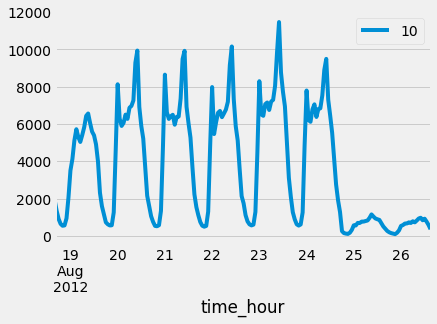

In [16]:
plt.figure(figsize=(20, 15))
users_df.plot(x='time_hour', y=bs)

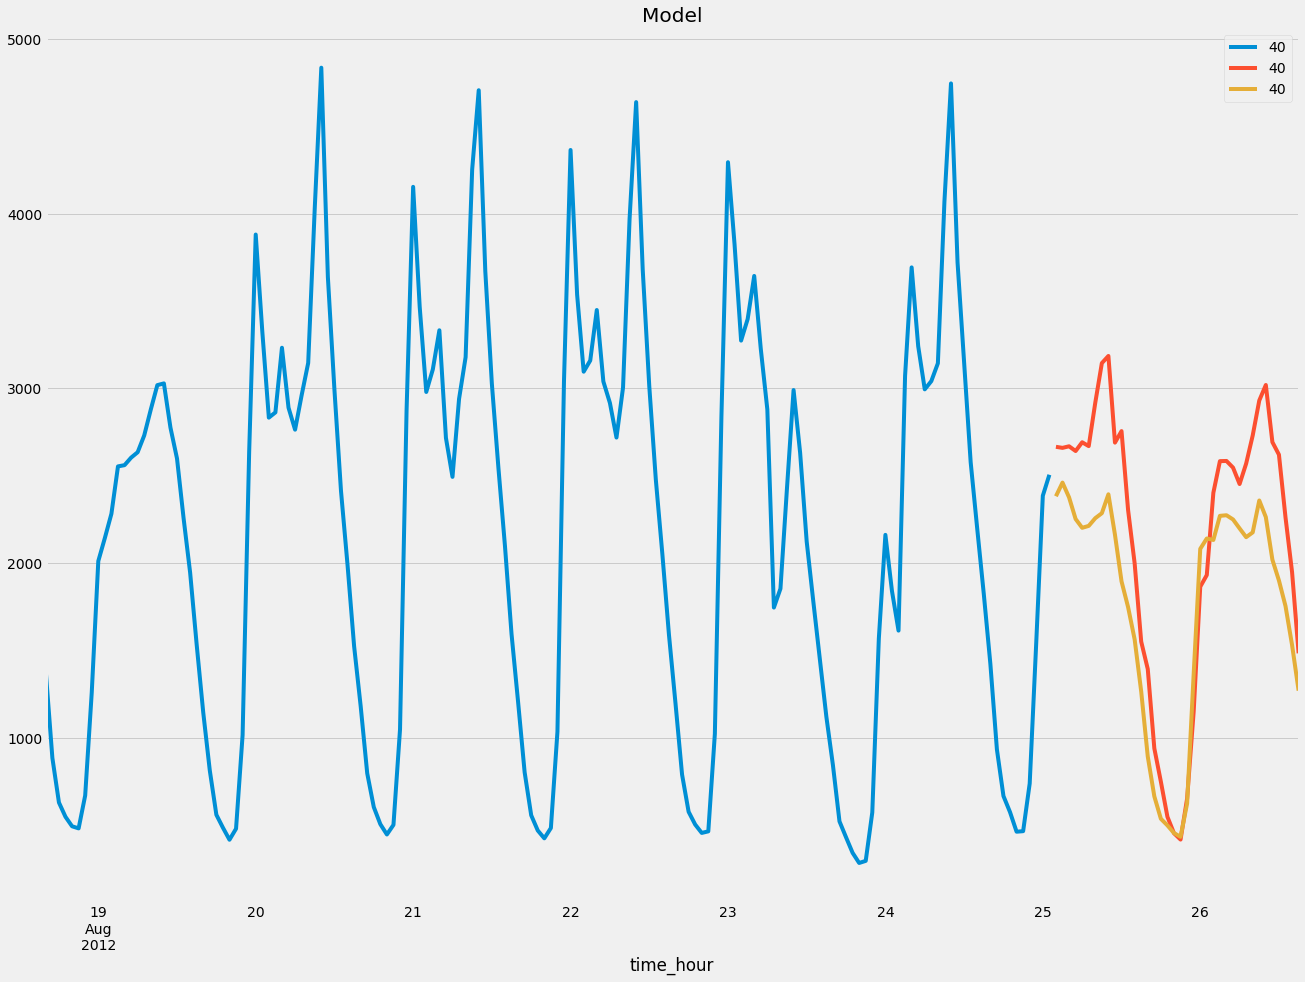

In [25]:
plt.figure(figsize=(20, 15))
plt.title('Model')
ax = plt.gca()
train.plot(x='time_hour', y=bs, ax=ax)
valid.plot(x='time_hour', y=bs, ax=ax)
prediction.plot(x='time_hour', y=bs, ax=ax)
plt.legend()

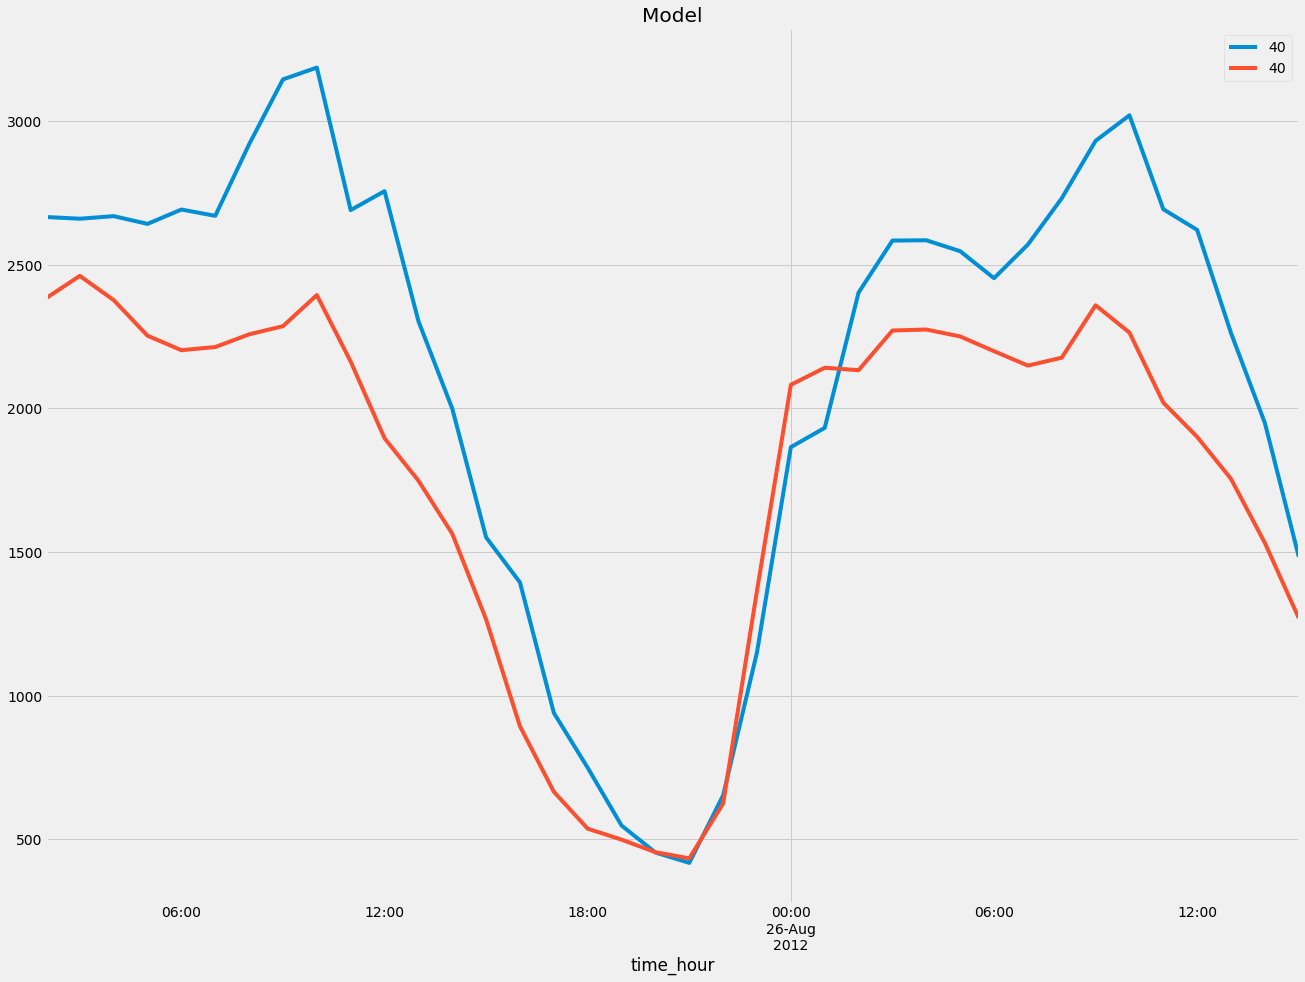

In [26]:
plt.figure(figsize=(20, 15))
plt.title('Model')
ax = plt.gca()
valid.plot(x='time_hour', y=bs, ax=ax)
prediction.plot(x='time_hour', y=bs, ax=ax)
plt.legend()

In [19]:
rmse = np.square(np.mean(x_pred - YTest)**2)
rmse

139919.23694088444

In [20]:
rmse = np.square(np.mean(prediction[bs].values - valid[bs].values)**2)
rmse

14300499543472.871